In [19]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

# Regression Analysis: Seasonal Effects with Sklearn Linear Regression
In this notebook, you will build a SKLearn linear regression model to predict Yen futures ("settle") returns with *lagged* Yen futures returns. 

In [20]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration
yen_futures = pd.read_csv(
    Path("Resources/yen.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,3401.0,NaN,3401.0,2.0,1.0
1976-08-03,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-04,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-05,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-06,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0


In [21]:
# Trim the dataset to begin on January 1st, 1990
yen_futures = yen_futures.loc["1990-01-01":, :]
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.0,6954.0,6835.0,6847.0,NaN,6847.0,48336.0,51473.0
1990-01-03,6877.0,6910.0,6865.0,6887.0,NaN,6887.0,38206.0,53860.0
1990-01-04,6937.0,7030.0,6924.0,7008.0,NaN,7008.0,49649.0,55699.0
1990-01-05,6952.0,6985.0,6942.0,6950.0,NaN,6950.0,29944.0,53111.0
1990-01-08,6936.0,6972.0,6936.0,6959.0,NaN,6959.0,19763.0,52072.0


# Data Preparation

### Returns

In [22]:
# Create a series using "Settle" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
returns = yen_futures.Settle.pct_change().replace(np.inf, np.nan).replace(-np.inf, np.nan).dropna() * 100.0

## Append to dataset and remove NaN rows
yen_futures["Returns"] = returns
yen_futures.dropna(inplace=True)

## Print
returns.head(10)

Date
1990-01-03    0.584197
1990-01-04    1.756933
1990-01-05   -0.827626
1990-01-08    0.129496
1990-01-09   -0.632275
1990-01-10   -0.404917
1990-01-11    0.087121
1990-01-12   -0.290149
1990-01-15    0.349192
1990-01-16    0.000000
Name: Settle, dtype: float64

### Lagged Returns 

In [23]:
# Create a lagged return using the shift function
returns_lag1 = returns.shift(1).dropna()

## Append to dataset and remove NaN rows
yen_futures["LaggedReturns"] = returns_lag1
yen_futures.dropna(inplace=True)

## Print
returns_lag1.head(10)

Date
1990-01-04    0.584197
1990-01-05    1.756933
1990-01-08   -0.827626
1990-01-09    0.129496
1990-01-10   -0.632275
1990-01-11   -0.404917
1990-01-12    0.087121
1990-01-15   -0.290149
1990-01-16    0.349192
1990-01-17    0.000000
Name: Settle, dtype: float64

### Train Test Split

In [24]:
# Create a train/test split for the data using 2018-2019 for testing and the rest for training
train = yen_futures[:'2017']
test = yen_futures['2018':]

In [25]:
# Create four dataframes:
# X_train (training set using just the independent variables), X_test (test set of of just the independent variables)
# Y_train (training set using just the "y" variable, i.e., "Futures Return"), Y_test (test set of just the "y" variable):
X_train = train.drop(columns=["Returns"])
Y_train = train.Returns.to_frame()

X_test = test.drop(columns=["Returns"])
Y_test = test.Returns.to_frame()


In [26]:
X_train

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest,LaggedReturns
Date,,,,,,,,,
2014-02-18,9831.0,9865.0,9734.0,9775.0,42.0,9775.0,203495.0,196924.0,0.409123
2014-02-19,9768.0,9825.0,9760.0,9773.0,2.0,9773.0,129508.0,197197.0,-0.427829
2014-02-20,9774.0,9837.0,9765.0,9775.0,2.0,9775.0,160202.0,198280.0,-0.020460
2014-02-21,9772.0,9776.0,9725.0,9758.0,20.0,9755.0,103091.0,202990.0,0.020465
2014-02-24,9752.0,9789.0,9740.0,9757.0,2.0,9757.0,90654.0,203114.0,-0.204604
...,...,...,...,...,...,...,...,...,...
2017-12-22,8871.0,8882.5,8864.5,8880.5,10.5,8881.0,71339.0,230870.0,0.084621
2017-12-26,8879.0,8898.5,8873.5,8884.5,10.5,8891.5,33864.0,229084.0,0.118370
2017-12-27,8887.0,8895.0,8869.0,8870.5,13.5,8878.0,86378.0,228295.0,0.118230


# Linear Regression Model

In [27]:
# Create a Linear Regression model and fit it to the training data
from sklearn.linear_model import LinearRegression

# Fit a SKLearn linear regression using just the training set (X_train, Y_train):
model = LinearRegression()
model.fit(X_train, Y_train)

LinearRegression()

# Make predictions using the Testing Data

Note: We want to evaluate the model using data that it has never seen before, in this case: X_test.

In [28]:
# Make a prediction of "y" values using just the test dataset
predictions = pd.DataFrame(model.predict(X_test), index=X_test.index)

In [29]:
# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
predicted_comparison = pd.concat([Y_test, predictions], axis="columns", join="inner")
predicted_comparison.columns=[ "ActualData", "PredictedData" ]

array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
      dtype=object)

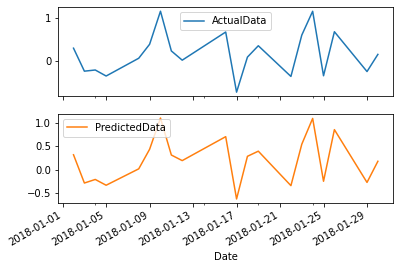

In [42]:
# Plot the first 20 predictions vs the true values
predicted_comparison[:20].plot(subplots=True)

# Out-of-Sample Performance

Evaluate the model using "out-of-sample" data (X_test and y_test)

In [31]:
from sklearn.metrics import mean_squared_error

# Calculate the mean_squared_error (MSE) on actual versus predicted test "y" 
mse_out = mean_squared_error(Y_test, predictions)

# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
rmse_out = np.sqrt(mse_out)

# Print
print(f"Mean Squared Error (MSE): {mse_out}")
print(f"Root Mean Squared Error (RMSE): {rmse_out}")

Mean Squared Error (MSE): 0.028607388052668496
Root Mean Squared Error (RMSE): 0.16913718707802994


# In-Sample Performance

Evaluate the model using in-sample data (X_train and y_train)

In [32]:
# Construct a dataframe using just the "y" training data:
in_sample_data = pd.DataFrame({"TrainingData": Y_train.Returns})

# Add a column of "in-sample" predictions to that dataframe:  
in_sample_data["InSamplePredictions"] = model.predict(X_train)

# Calculate in-sample mean_squared_error (for comparison to out-of-sample)
mse_in = mean_squared_error(Y_train, in_sample_data.InSamplePredictions)

# Calculate in-sample root mean_squared_error (for comparison to out-of-sample)
rmse_in = np.sqrt(mse_in)

# Print
print(f"Mean Squared Error (MSE): {mse_in}")
print(f"Root Mean Squared Error (RMSE): {rmse_in}")

Mean Squared Error (MSE): 0.02626851739283526
Root Mean Squared Error (RMSE): 0.1620756533006585


# Conclusions

In [33]:
# Build composite MSE/RMSE table
results = pd.DataFrame({"In-Sample Performance": [mse_in, rmse_in],
    "Out-of-Sample Performance": [mse_out, rmse_out]},
    index=["MSE", "RMSE"])
results

,In-Sample Performance,Out-of-Sample Performance
MSE,0.026269,0.028607
RMSE,0.162076,0.169137


## CONCLUSIONS:

1. MSE and RMSE are similar between in- and out-of-sample performance. This leads to the conclusion that the model makes predictions with similar accuracy for both the trained and test data.

2. MSE and RMSE values are favorable (MSE < .05), indicating that the model is accurate.